# Node A (Research Track 2 Assignment 2)
#### Jan Drozd (s5646665)

Imports

In [1]:
%matplotlib widget
    
import rospy
import actionlib
import threading
import time

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.figure import Figure

import ipywidgets as w

from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from geometry_msgs.msg import Point, Pose, Twist
from assignment_2_2022.msg import *
from assignment_2_2022.srv import Service1

goal_reach_count = 0
goal_cancel_count = 0 

NodeA class

In [2]:
class NodeA:
    def __init__(self):
        self.robot_pos_x = 0.0
        self.robot_pos_y = 0.0
        self.goal_pos_x = 0.0
        self.goal_pos_y = 0.0

        self.goal_counter = 0

        self.robot_traj_x = []
        self.robot_traj_y = []

        self.goal_hist_x = []
        self.goal_hist_y = []

        self.is_moving = False 

        self.fig, self.ax = plt.subplots()

        self.pub = rospy.Publisher('/robot_data', Message1, queue_size = 1)
        self.sub = rospy.Subscriber('/odom', Odometry, self.UpdateInfo)

        rospy.wait_for_service('goal_info')      
        self.srv = rospy.ServiceProxy('goal_info', Service1)

        self.reached_goals_fig, self.reached_goals_ax = plt.subplots()

    def MapInit(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.set_title('Positions of the robot and goals')
        self.ax.set_xlabel('x [m]')
        self.ax.set_ylabel('y [m]')
        return self.map_rob, self.map_goal_cur, self.map_goal_his
    
    def MapUpdate(self, frame):
        self.map_rob.set_data(self.robot_trajectory_x, self.robot_trajectory_y)
        self.map_goal_cur.set_data(self.goal_pos_x, self.goal_pos_y)
        self.map_goal_his.set_data(self.goal_history_x, self.goal_history_y)
        return self.map_rob, self.map_goal_cur, self.map_goal_his
        
    def GoalObserv(self):
        while not rospy.is_shutdown():
            goals = self.srv(0)
            global goal_reach_count, goal_cancel_count
            goal_reach_count = goals.reached
            goal_cancel_count = goals.cancelled
            time.sleep(1)
    
    def GoalClient(self):
        self.client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
        rospy.loginfo('Waiting for server.')
        self.client.wait_for_server()
        self.goal = PlanningGoal()
        rospy.spin()
    
    def UpdateInfo(self, msg):
        self.robot_pos_x = msg.pose.pose.position.x
        self.robot_pos_y = msg.pose.pose.position.y
        self.robot_traj_x.append(self.robot_pos_x)
        self.robot_traj_y.append(self.robot_pos_y)
        info = Message1()
        info.x = msg.pose.pose.position.x
        info.y = msg.pose.pose.position.y
        info.vel_x = msg.twist.twist.linear.x
        info.vel_y = msg.twist.twist.linear.y
        self.pub.publish(info)
            
    def Interface(self):
        rospy.loginfo('User interface.')
        
        self.new_goal_x = w.FloatSlider(
            value=0.0,
            min=-10,
            max=10.0,
            step=0.1,
            description='Goal x',
            continuous_update=False
        )

        self.new_goal_y = w.FloatSlider(
            value=0.0,
            min=-10,
            max=10.0,
            step=0.1,
            description='Goal y',
            continuous_update=False
        )

        self.new_goal_button = w.Button(description='Submit new goal')
        self.new_goal_button.on_click(self.ClickHandler)
        
        display(w.HBox([self.new_goal_x, self.new_goal_y, self.new_goal_button]))
        
    def ClickHandler(self, b):
        self.goal.x = self.new_goal_x.value
        self.goal.y = self.new_goal_y.value
        self.client.send_goal(self.goal)
        self.client.wait_for_result()

    def GoalsInit(self):
        self.reached_goals_ax.set_title('Reached vs Not-Reached Goals')
        self.reached_goals_ax.set_xlabel('Time [s]')
        self.reached_goals_ax.set_ylabel('Number of Goals')
        self.reached_goals_line, = self.reached_goals_ax.plot([], [], label='Reached Goals')
        self.not_reached_goals_line, = self.reached_goals_ax.plot([], [], label='Not Reached Goals')
        return self.reached_goals_line, self.not_reached_goals_line

    def GoalsUpdate(self, frame):
        self.reached_goals_line.set_ydata(goal_reach_count)
        self.not_reached_goals_line.set_ydata(goal_cancel_count)
        return self.reached_goals_line, self.not_reached_goals_line


Node init

[INFO] [1685687615.349526, 0.000000]: This is the user interface.


[INFO] [1685687615.766503, 0.000000]: Waiting for server.


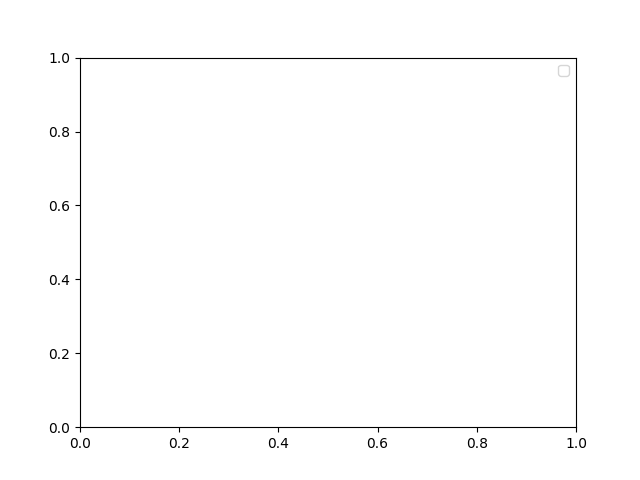

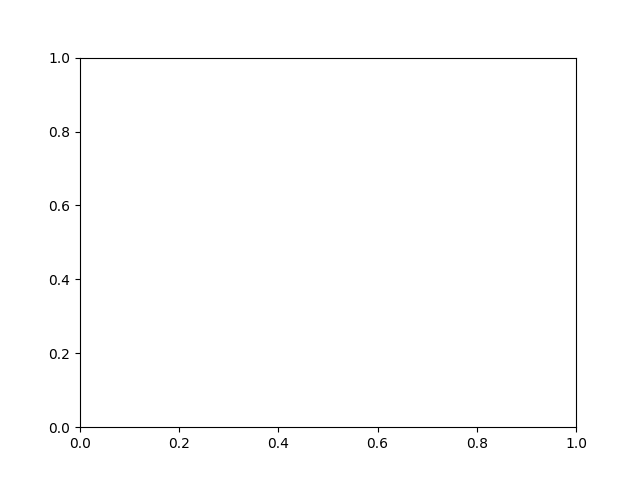

In [3]:
rospy.init_node('node_a')
node_robot = NodeA()
node_robot.Interface()

# Start threads
threading.Thread(target=node_robot.GoalClient).start()
threading.Thread(target=node_robot.GoalObserv).start()

# Start map animation
anim = FuncAnimation(node_robot.fig, node_robot.MapUpdate, init_func=node_robot.MapInit, cache_frame_data=False)

# Show plot
plt.legend()
plt.show(block=False)


Nearest obstacle

In [5]:
nearest_obstacle = w.FloatText(value=0.0, description='Nearest obstacle:', readout_format='.3f')

def LaserCallback(msg):
    nearest_obstacle.value = min(msg.ranges)

rospy.Subscriber('/scan', LaserScan, LaserCallback)
display(nearest_obstacle)

FloatText(value=0.0, description='Nearest obstacle:')

Plot of reached goals

In [ ]:
goals_anim = FuncAnimation(node_robot.reached_goals_fig, node_robot.GoalsUpdate, init_func=node_robot.GoalsInit, cache_frame_data=False)